# Course project

## (C) Visual search with k-NN

### Instructions

The idea here is to implement a little search engine based on the high-level image representation and k-nearest neighbors

1. Fit and tune a k-NN classifier
2. Pick an image from the test set and plot its 10 nearest neighbors from the train set

**Hint:** take a look at the $kneighbors()$ method from Scikit-learn k-NN estimators.

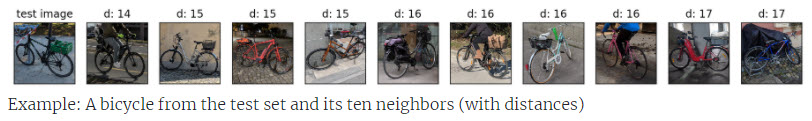

In [1]:
from IPython.display import Image as Im
Im(filename="bike.jpg")

### Task C
* Load data from npz file
* Calculate baseline with DummyClassifier
* Fit k-NN Classifier wit train set
* Tune k-NN Classifier using ParameterGrid with validation set
* Calculate accuracy of tuned k-NN Classifier on test set
* Use Nearestneighbors estimator to identify 10 nearest images and plot them

#### Load data
* from npz file saved in previous workbook
* no need to split train/validation sets as they are already separated
* calculate baseline using DummyClassifier

In [2]:
import numpy as np
import pandas as pd

In [3]:
with np.load('swissroads_highlevel_features.npz', allow_pickle=False) as npz_file:
    # Load the arrays
    features_tr = npz_file['features_train']
    labels_tr = npz_file['labels_train']
    features_va = npz_file['features_valid']
    labels_va = npz_file['labels_valid']
    features_te = npz_file['features_test']
    labels_te = npz_file['labels_test']
    imgs_tr = npz_file['imgs_train']
    imgs_va = npz_file['imgs_valid']
    imgs_te = npz_file['imgs_test']

print('features_tr:', features_tr.shape)
print('labels_tr:', labels_tr.shape)
print('features_va:', features_va.shape)
print('labels_va:', labels_va.shape)
print('features_te:', features_te.shape)
print('labels_te:', labels_te.shape)
print('imgs_tr:', imgs_tr.shape)
print('imgs_va:', imgs_va.shape)
print('imgs_te:', imgs_te.shape)

features_tr: (280, 2048)
labels_tr: (280,)
features_va: (139, 2048)
labels_va: (139,)
features_te: (50, 2048)
labels_te: (50,)
imgs_tr: (280, 299, 299, 3)
imgs_va: (139, 299, 299, 3)
imgs_te: (50, 299, 299, 3)


In [4]:
X_tr = features_tr
X_va = features_va
X_te = features_te
y_tr = labels_tr
y_va = labels_va
y_te = labels_te
labels = ['bike','car','motorcycle','other','truck','van']

In [5]:
pd.value_counts(y_tr, normalize=True)

0.0    0.235714
1.0    0.228571
2.0    0.182143
4.0    0.150000
3.0    0.114286
5.0    0.089286
dtype: float64

In [6]:
#pd.value_counts(y_va, normalize=True)

#### i) Baseline

In [7]:
from sklearn.dummy import DummyClassifier

# Create the dummy classifier
dummy = DummyClassifier(strategy='most_frequent')

In [8]:
# Fit it
dummy.fit(X_tr, y_tr)

# Compute test accuracy
baseline_accuracy = dummy.score(X_va,y_va)
print('Accuracy: {:.2f}'.format(baseline_accuracy))

Accuracy: 0.24


In [9]:
%store baseline_accuracy

Stored 'baseline_accuracy' (float64)


In [10]:
# "Most-frequent" predictions
y_pred_dummy = dummy.predict(X_va)
print('Predicted:', y_pred_dummy[30:50], '..')
print('True labels:', y_va[30:50], '..') 

Predicted: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ..
True labels: [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] ..


#### ii) k-NN Classifier

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [12]:
# Create pipeline
k_nn_pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('k_nn',KNeighborsClassifier(algorithm='brute'))
])

# Fit estimator
k_nn_pipe.fit(X_tr, y_tr)

# Evalute in validation set
print('Accuracy: {:.3f}'.format(k_nn_pipe.score(X_va, y_va)))

Accuracy: 0.935


#### iii) Tune Hpyerparameters using ParameterGrid for grid search

In [13]:
k_nn_pipe.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('k_nn', KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))])>

In [14]:
# Define a set of reasonable values
k_values = np.arange(1,21) # number of neighbors
weights_functions = ['uniform','distance'] # weighting function
distance_types = [1,2] # distance metric

In [15]:
from sklearn.model_selection import ParameterGrid

# Define a grid of values
grid = ParameterGrid({
    'k_nn__n_neighbors': k_values,
    'k_nn__weights': weights_functions,
    'k_nn__p': distance_types
})

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 80


In [16]:
# Create pipeline
knn_pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('k_nn',KNeighborsClassifier())
])

# save accuracy on test results
test_results = []

# Get params
for params_grid in grid:
    knn_pipe.set_params(**params_grid)
    knn_pipe.fit(X_tr,y_tr)
    params_grid['accuracy_train'] = knn_pipe.score(X_tr,y_tr)
    params_grid['accuracy_validation'] = knn_pipe.score(X_va,y_va)
    test_results.append(params_grid)

In [17]:
pd.DataFrame(test_results).sort_values(by='accuracy_validation', ascending=False).head(10)

,accuracy_train,accuracy_validation,k_nn__n_neighbors,k_nn__p,k_nn__weights
16,0.935714,0.942446,5,1,uniform
23,1.000000,0.942446,6,2,distance
8,0.960714,0.942446,3,1,uniform
10,0.957143,0.942446,3,2,uniform
11,1.000000,0.942446,3,2,distance
14,0.950000,0.942446,4,2,uniform
15,1.000000,0.942446,4,2,distance
19,1.000000,0.935252,5,2,distance
22,0.935714,0.935252,6,2,uniform
4,0.950000,0.935252,2,1,uniform


In [18]:
# Create final Pipeline based on hypterparameter gird search tuning
knn_pipe_final = Pipeline([
    ('scaler',StandardScaler()),
    ('k_nn',KNeighborsClassifier(n_neighbors=5,p=1,weights='uniform'))
])

# Fit estimator
knn_pipe_final.fit(X_tr,y_tr)
# Calculate accuracy on test set
knn_accuracy = knn_pipe_final.score(features_te,labels_te)
print('k-NN Classifier accuracy: {:.3f}'.format(knn_accuracy))

k-NN Classifier accuracy: 0.900


In [19]:
%store knn_accuracy

Stored 'knn_accuracy' (float64)


#### iv) Pick image from test set and plot its 10 nearest neighbors from train set

In [20]:
from sklearn.neighbors import NearestNeighbors

[Link to documentation on 'NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html)

In [21]:
nn = NearestNeighbors(n_neighbors=10)
nn.fit(X_tr)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=10, p=2, radius=1.0)

In [22]:
nn.kneighbors(X_tr, n_neighbors=5, return_distance=False)

array([[  0, 224,  20, 238, 262],
       [  1, 233,  88, 195,  50],
       [  2,  44,  90, 200, 257],
       ...,
       [277, 172,  64, 122, 176],
       [278,  21, 276,  76, 198],
       [279, 148, 196,  66,  82]], dtype=int64)

In [23]:
# indexes of images in the trian set that are the closest to the one select in test set
search = 24
near10 = nn.kneighbors(features_te[search].reshape(1,2048), return_distance=False) # had to re-shape to have 2D instead of 1D array
near10

array([[ 62, 203, 202, 161, 226,  71,  43, 159, 238, 169]], dtype=int64)

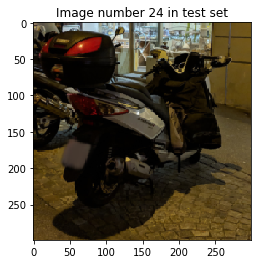

In [24]:
import matplotlib.pyplot as plt
plt.imshow(imgs_te[search])
plt.title('Image number {} in test set'.format(search))
plt.show()

In [25]:
print('Labels train 10 nearest:',labels_tr[near10])
print('Label test image:',labels_te[search])

Labels train 10 nearest: [[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]
Label test image: 2.0


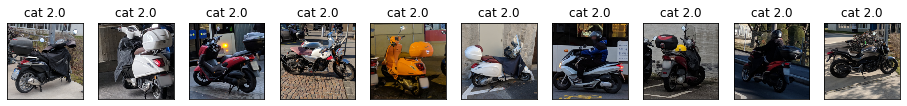

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(16, 16))

x = 0
for ind in near10:
    for i in ind:
        #n = pd.DataFrame(labels_tr)[pd.DataFrame(labels_tr)[0] == category].index[0]

        axes[x].set_title('cat {}'.format(labels_tr[i]))
        axes[x].imshow(imgs_tr[i])
        axes[x].get_xaxis().set_visible(False) # Disable x-axis
        axes[x].get_yaxis().set_visible(False) # Disable y-axis
        x = x + 1
plt.show()
# how to replace one-hot encoded by true names?

### Notes/Questions Task C (Greg)
* Can I include NearestNeighbors directly in initial Pipeline where I fit and tune k-NN Classifier? Or need to build as new object (as I did) as tihs one is unsupervised learning? *(cell 21)*
* Shall I have standardize data for Nearestneighbors task? *(cell 21)*